# Step by step PCA on IMDB-Movie-data.csv

In [29]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. a ipython magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns; sns.set(style="ticks", color_codes=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
class PCAModel:
    """
    Principal component analysis (PCA)
    
    Parameters
    ----------
    n_components : int
        top number of principal components to keep
    
    features: list
        a list of features, for printing purpose only!
    """

    def __init__(self, n_components, features):
        self.n_components = n_components
        self.features = np.array(features)
        self.var_exp = []

    def fit(self, X):
        # standardize
        X = X.copy()
        self.mean = np.mean(X, axis = 0)
        self.scale = np.std(X, axis = 0)
        X = (X - self.mean) / self.scale
        
        # eigendecomposition
        eig_vals, eig_vecs = np.linalg.eig(np.cov(X.T)) # calculate eigen values and vectors
        
        # descenting order eigenvalues, eigenvectors and features by eigenvalues!
        idx = eig_vals.argsort()[::-1]
        self.eig_vals = eig_vals[idx]
        self.eig_vecs = eig_vecs[idx]
        self.features = self.features[idx]
        
        self.components = eig_vecs[:, :self.n_components] # get the first n_components of eigen vectors
        self.var_exp = self.eig_vals / np.sum(self.eig_vals) # calculate the explained variance
        return self

    def transform(self, X):
        X = X.copy()
        X = (X - self.mean) / self.scale
        X_pca = np.dot(X, self.components)
        return X_pca

### Read the dataset

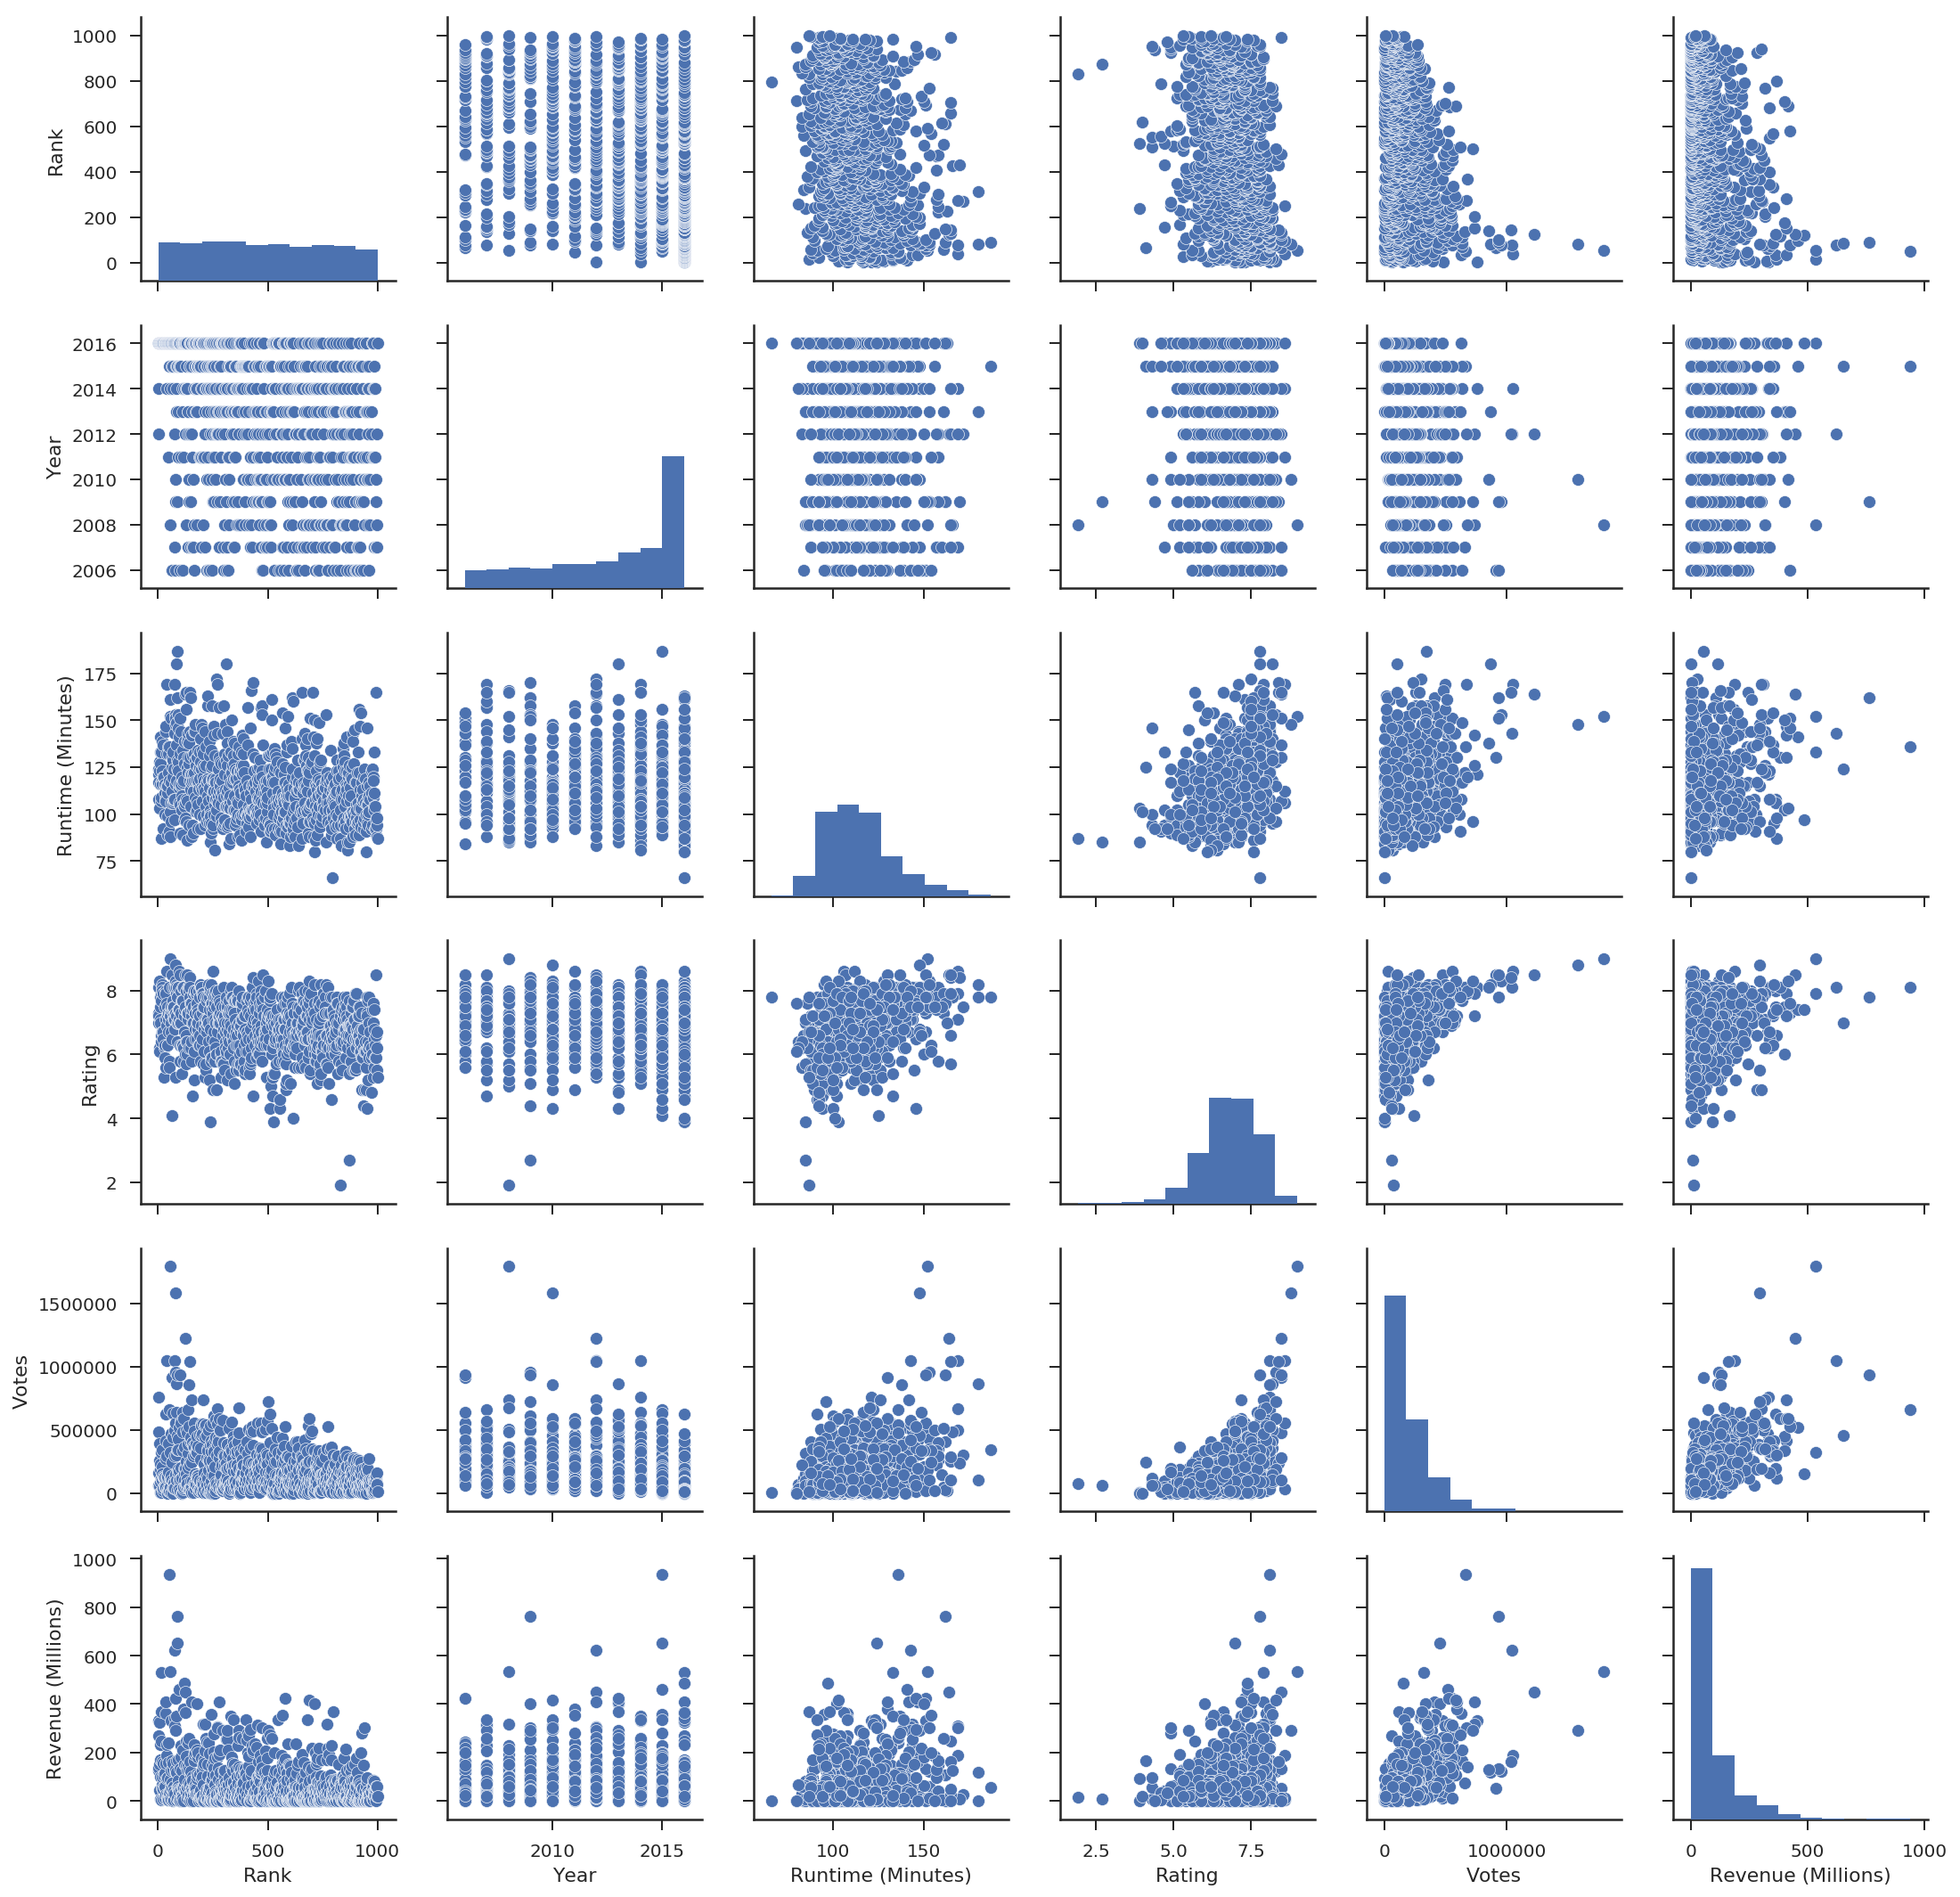

In [31]:
filename = 'IMDB-Movie-Data.csv'
features = ['Rank','Title','Genre','Description','Director','Actors','Year','Runtime (Minutes)', 
            'Rating','Votes','Revenue (Millions)']

###,'Metascore']
data = pd.read_csv(filename).dropna() # Drop rows with NA values so there is on infuluence in the distribution.

# y-variable
target = ['Metascore']

# Select only numeric columns - Integers and floats as this would simplify the data handling
data = data.select_dtypes(include=['int64','float'])

# Replace every NaN values with 0 (we don't have NaN values)
# data.fillna(value=0,axis=1,inplace=True)

# print(data)

features_numeric =  ['Rank','Year','Runtime (Minutes)', 
            'Rating','Votes','Revenue (Millions)']

X = data[features_numeric] # X = numeric features from dataset
y = data[target] # y = Metascore from dataset

sns.pairplot(X)
plt.show()

For example, we can observe from the plot that there's linear relationship between 'Revenue' and 'Votes', thus we probably don't need to include both of them. If it is the case that one of the features is considered redundant, we should be able to summarize the data with less characteristics (features). So, the way PCA tackles this problem is: Instead of simply picking out the useful features and discarding the others, it uses a linear combination of the existing features and constructs some new features that are good alternative representation of the original data.

### Define the PCA model

In [32]:
print('Number of features: ', X.shape[1])
list_of_features = list(X.columns)
print('Features: ', list_of_features)
print('------------------------------------------------------------------------------------------------')

# select the reduction of X's features
number_components = 2
print('Number of components: ', number_components)

# using PCAmodel class
pca_model = PCAModel(n_components = number_components, features=list_of_features).fit(X)
print('Features with most information about the distribution of data: ', pca_model.features[:number_components])
print('------------------------------------------------------------------------------------------------')

print('Eigen values: ', pca_model.eig_vals)
print('------------------------------------------------------------------------------------------------')

# using library to confirm results
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
pca = PCA(n_components = number_components).fit(X_std)

# print explained ratio to see if the matches
print('Explained ratio calculated by sklearn: ', pca.explained_variance_ratio_)
print('Explained ratio calculated from scratch: ', pca_model.var_exp[:number_components])

('Number of features: ', 6)
('Features: ', ['Rank', 'Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)'])
------------------------------------------------------------------------------------------------
('Number of components: ', 2)
('Features with most information about the distribution of data: ', array(['Rank', 'Year'],
      dtype='|S18'))
------------------------------------------------------------------------------------------------
('Eigen values: ', array([ 2.48806706,  1.3291852 ,  0.8403024 ,  0.64612746,  0.47316999,
        0.23031635]))
------------------------------------------------------------------------------------------------
('Explained ratio calculated by sklearn: ', array([ 0.414183  ,  0.22126651]))
('Explained ratio calculated from scratch: ', array([ 0.414183  ,  0.22126651]))


We can confirm the correctness of the PCA model since it has exactly the same explained ratio with sklearn library.<br />We chose `number_components` = 2 randomly.<br />From the output above, we can observe the eigenvalues for all the features.<br />If we want, we are able to choose a different value for `number_components`.

### Choosing Top K Eigenvectors

There is no correct answer when we are asked how many attributes should we choose.<br /> It can be somewhere between `1` and `p`, where `p` is `number of features`!<br />  

Think of a `Principal Component(PC)` as a street in a town you have never visited before. How many streets should it take you to get to know the town?

Well, you should obviously visit the main street (the first component), and maybe some of the other big streets too. Do you need to visit every street to know the town well enough? **Probably not.**

For you to get to know the town **literally perfectly**, **you should visit all of the streets**. But this takes too much time.<br /> What if you could visit, let's say, 10 out of the 50 streets, and have a 95% understanding of the town? That should be good enough.

Basically, you should select as many components as the level of your desired comfort with your data!

See the plot below for more:

('Variance Explained: ', array([ 0.414183  ,  0.22126651,  0.13988328,  0.1075594 ,  0.07876756,
        0.03834025]))
('Cumulative Variance Explained: ', array([ 0.414183  ,  0.63544951,  0.77533279,  0.88289219,  0.96165975,  1.        ]))


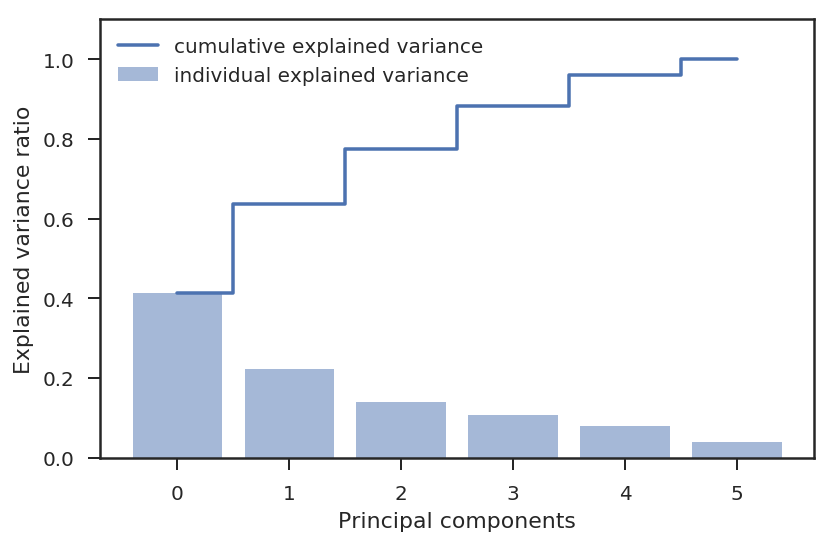

In [33]:
cum_var_exp = np.cumsum(pca_model.var_exp)
print('Variance Explained: ', pca_model.var_exp)
print('Cumulative Variance Explained: ', cum_var_exp)

plt.bar(range(pca_model.var_exp.shape[0]), pca_model.var_exp, alpha = 0.5, 
        align = 'center', label = 'individual explained variance')
plt.step(range(pca_model.var_exp.shape[0]), cum_var_exp, 
         where = 'mid', label = 'cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.ylim(0, 1.1)
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

The plot above clearly shows that most of the variance (41%) can be explained by the `Principal Component 0(PC0)` alone.
The `Principal Component 1(PC1)` has the 22% data's varation, PC2 has 13% of it and so on.. <br /> _Principal Components 4 and 5 can be dropped without losing too much information._<br />  **The first 4 principal components** represent 88% of the variance.<br />  Or in other words, they **contain 88% of the information.**

# Comparison with Linear Regression
Let's try to learn our 'city' by walking only on some main roads.

('R-Squared Value(R^2): ', 0.45579814034599142)


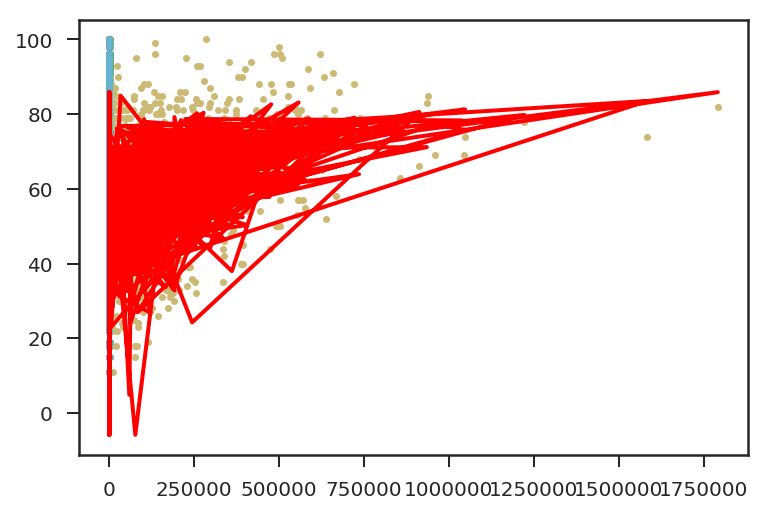

In [56]:
# Libraries
from sklearn import linear_model

# Friendly Reminder:
# X = data[features_numeric] # X = numeric features from dataset
# y = data[target] # y = Metascore from dataset

y = data[target]

lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
# print(predictions)
Rsquared = lm.score(X,y)
print('R-Squared Value(R^2): ', Rsquared)    # 0% indicates that the model explains none of the variability /
                            # of the response data around its mean.
                            # 100% indicates that the model explains all the variability  /
                            # of the response data around its mean.
            



import matplotlib.pyplot as plt
# first, plot the observed data
plt.plot(X, y,'.')

# then, plot the least squares line
plt.plot(X, predictions, c='red', linewidth=2)


# Principal Component Regression(PCR)
We will try now to do a linear regression **after** the Principal Component Analysis.<br/>
This is called otherwise `Principal Component Regression(PCR).`<br/>

('Intercept : ', array([ 59.575179]))
('Coefficients: ', array([[  2.92058770e-05,   6.12397547e-03]]))
('Residuals: ', 0.12041527132502894)


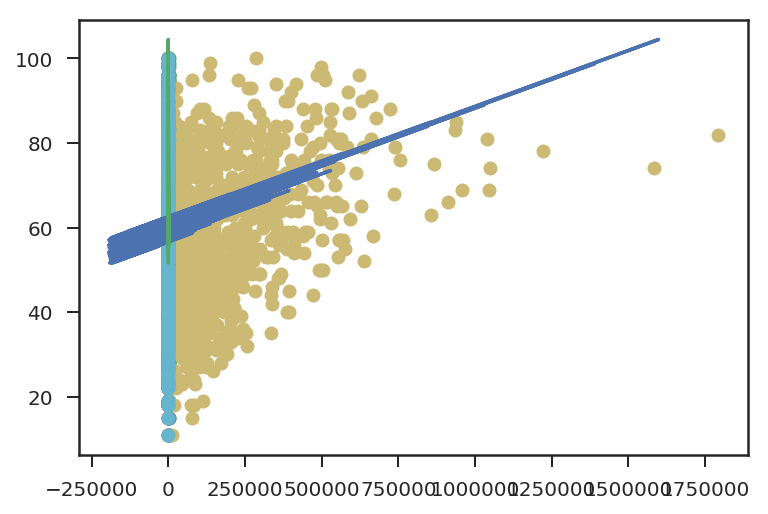

In [57]:
X_pca = pca.fit_transform(X) # fit and transform your X's.

lm.fit(X_pca,y) # Apply linear model fit

# Print Intercept, Coefficients & Residuals
print("Intercept : ", lm.intercept_)
print("Coefficients: ", lm.coef_)
print("Residuals: ", lm.score(X_pca,y))
# print lm.residues_

# Predictions
y_fit = lm.predict(X_pca)

# Plot prediction against given observations
plt.plot(X,y,'o')
plt.plot(X_pca,y_fit)